# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

In [1]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random

# Mount Google Drive
drive.mount('/content/drive')
# !cp -r /content/drive/Shareddrives/Deep\ Learning/Final/Data /content/sample_data

zip_path = '/content/drive/MyDrive/DeepLearning_2023/Final/poker-database.zip'
data_path = '/content/poker/'
results_path = '/content/drive/MyDrive/DeepLearning_2023/Final/Results'


Mounted at /content/drive


In [2]:
# unzip database (no need to run if already in disk)
import zipfile
import os

if not os.path.exists(data_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

# Dataset and Dataloader


In [5]:
# First we will do data augmentation
import torchvision.transforms as tf
from PIL import Image
import os

num_iterations = 2

transform = tf.RandomPerspective(distortion_scale=0.6, p=1.0)
#transform = tf.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1))

root_dir = data_path + "train"

# Get the classes of the dataset
classes = os.listdir(root_dir)
classes.sort()

for class_name in classes:
    # Get the image paths of the current class
    class_dir = os.path.join(root_dir, class_name)
    image_files = os.listdir(class_dir)

    for idx, image_file in enumerate(image_files):
        # Check that it is not a dir
        if(not os.path.isdir(image_file)):
            # Open the image
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)

            for i in range(num_iterations):
                # Apply the transformations
                transformed_image = transform(image)
                transformed_image.save(f"{class_dir}/image_{idx}_augmented_{i}.jpg")


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as tf
from PIL import Image
import os

# Define labels_to_number and number_to_labels dictionaries
labels_to_number = {}
number_to_labels = {}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_path = []
        self.labels = []

        # Get the classes of the dataset
        classes = os.listdir(root_dir)
        classes.sort()

        for label_idx, class_name in enumerate(classes):

            # Create the dictionaries
            labels_to_number[class_name] = label_idx
            number_to_labels[label_idx] = class_name

            # Get the image paths of the current class
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)

            for image_file in image_files:
                # Open the image
                image_path = os.path.join(class_dir, image_file)

                if(not os.path.isdir(image_path)):
                    self.images_path.append(image_path)

                    self.labels.append(labels_to_number[class_name])

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = Image.open(image_path)

        # Apply the preprocessing
        image = self.transform(image)

        label = self.labels[idx]
        return image, label


# Compose the transformations
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor()
   # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 256
#batch_size = 50

# Define the train loader
train_dataset = Dataset(data_path + "/train", tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the validation loader
val_dataset = Dataset(data_path + "/valid", tr)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Load the test dataset
test_dataset = Dataset(data_path + '/test', tr)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Number of Classes
class_count = len(labels_to_number)
print(f"classes: {class_count}")
print(f"images: {len(train_dataset)}")

classes: 53
images: 7624


Label: jack of clubs


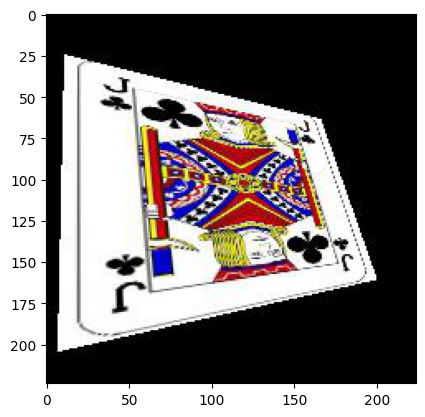

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

example_image, example_label = images[0].permute(1, 2, 0), labels[0]

print('Label: ' + str(number_to_labels[example_label.item()]))
plt.imshow(example_image)

In [4]:
import gc

# Train function
def train(CNN, train_loader, val_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train()  # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    val_losses_list = []
    criterion = nn.CrossEntropyLoss()

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Training
        loss_avg = 0
        nBatches = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches += 1

            if (i + 1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

        print('Epoch [{}/{}], Training Loss: {:.4f}'
              .format(epoch + 1, num_epochs, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)

        # Validation
        CNN.eval()  # Set the model in evaluation mode
        val_loss_avg = 0
        val_nBatches = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                outputs = CNN(images)
                val_loss = criterion(outputs, labels)
                val_loss_avg += val_loss.cpu().item()
                val_nBatches += 1

        val_loss_avg /= val_nBatches
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss_avg))
        val_losses_list.append(val_loss_avg)
        print(f'Validation Accuracy: {test(model, val_loader)}')

        CNN.train()  # Set the model back to train mode

        # Check if the results directory exists, or create it
        if not os.path.exists(results_path):
          os.makedirs(results_path)

        torch.save(CNN.state_dict(), results_path + '/' + model_name)

    return losses_list, val_losses_list


# Test funcion
def test(CNN, test_loader):
  CNN.eval()
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # return accuracy
        return 100 * correct / total

In [8]:
def plot_loss(loss_hist, val_loss_hist, model_name, num_epochs):

  # visualize the results
  plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
  plt.plot(val_loss_hist,'-b', linewidth=1.0, label='val_loss')
  plt.xlabel('train step', fontsize=14)
  plt.ylabel('loss', fontsize=14)
  plt.title(model_name)
  plt.legend()
  plt.savefig(results_path + f"Loss_{model_name}.png")
  plt.show()

In [9]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

## DenseNet161 Transfer Learning


In [ ]:
from torchvision.models import densenet161, DenseNet161_Weights

gc.collect()
torch.cuda.empty_cache()

# Load pre-trained Densenet161 model
weights = DenseNet161_Weights.IMAGENET1K_V1
model = densenet161(weights=weights)

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the last layer
num_features = model.classifier.in_features

model.classifier = nn.Linear(num_features, 53)

#Initialize optimizer
learning_rate = .01
#optimizer = torch.optim.Adam(model.classifier.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.classifier.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer, num_epochs=10, model_name='densenet161.ckpt', device=device)
plot_loss(losses_list, val_losses_list, "densenet161", 10)


#Evaluate the model
acc = test(model, val_loader)
print('Accuracy densenet161 Transfer Learning: ' + str(acc))

NameError: ignored

## Simple ConvNet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
  def __init__(self, in_channels, out_channels, expansion=1, stride=1):
    super(Bottleneck, self).__init__()

    bottleneck_channels = in_channels * expansion

    #A bottleneck is the sequence of a 1x1xexpanded_channels convolution, a 3x3xexpanded_channels conv and a 1x1xout_channels
    self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1)
    self.batchnorm1 = nn.BatchNorm2d(bottleneck_channels)
    self.relu = nn.ReLU()

    self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, groups=bottleneck_channels)
    self.batchnorm2 = nn.BatchNorm2d(bottleneck_channels)

    self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1)
    self.batchnorm3 = nn.BatchNorm2d(out_channels)

  def forward(self, x):

    out = self.conv1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.batchnorm3(out)
    out = self.relu(out)

    return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenetv2 Style Architecture
class MyModelv2(nn.Module):
    def __init__(self, num_classes=10):

        super(MyModelv2, self).__init__()
        '''
        REPLACE WITH YOUR CODE HERE
        '''
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.relu = nn.ReLU()

        self.bottleneck1 = Bottleneck(32, 16, expansion=4)
        self.bottleneck2 = Bottleneck(16, 16, expansion=6)
        self.bottleneck3 = Bottleneck(16, 24, expansion=6)
        self.bottleneck4 = Bottleneck(24, 24, expansion=6)
        self.bottleneck5 = Bottleneck(24, 32, expansion=6)
        self.bottleneck6 = Bottleneck(32, 32, expansion=6)
        self.bottleneck7 = Bottleneck(32, 64, expansion=6)


        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(128)

        #Global averaging Pooling of Mobilenet.
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)

        self.linear = nn.Linear(128,num_classes)


    def forward(self, x):
        #return self.linear(x.view(x.shape[0],-1))
        '''
        REPLACE WITH YOUR CODE HERE
        '''
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.bottleneck1(out)
        out = self.bottleneck2(out)
        out = self.bottleneck3(out)
        out = self.bottleneck4(out)
        out = self.bottleneck5(out)
        out = self.bottleneck6(out)
        out = self.bottleneck7(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)

        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        print(out.shape)

        out = self.linear(out)

        return out


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Load pre-trained ResNet-50 model
model = MyModelv2(num_classes=class_count)

#Initialize optimizer
learning_rate = .1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer, num_epochs=10, model_name='MyModelv2.ckpt', device=device)
plot_loss(losses_list, val_losses_list, "MyModelv2_svhn", 10)


In [ ]:
#MyModelv2 accuracy
my_net = MyModelv2(num_classes=53)
my_net.load_state_dict(torch.load(results_path + 'MyModelv2.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MyModelv2: ' + str(acc))

# VGG16

In [5]:
# code adapted from: https://www.kaggle.com/code/abdallahwagih/effecientnetb3-cards-classification-98-85

from torchvision.models import vgg16

import random
import math

#Initialize random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# free cuda memory
gc.collect()
torch.cuda.empty_cache()

model = vgg16(weights='DEFAULT')

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.Linear(512, 53)
)

parameters = list(model.classifier.parameters())
layers_n = len(model.features)

# there are 9 sequentials in features, we will train half of them
for i in range(math.ceil(layers_n / 2), layers_n):
  parameters += list(model.features[i].parameters())
  for param in model.features[i].parameters():
      param.requires_grad = True


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]


cuda:0
Epoch [1/10], Step [10/90], Loss: 4.3167
Epoch [1/10], Step [20/90], Loss: 4.1499
Epoch [1/10], Step [30/90], Loss: 4.1124
Epoch [1/10], Step [40/90], Loss: 4.0803
Epoch [1/10], Step [50/90], Loss: 4.0582
Epoch [1/10], Step [60/90], Loss: 4.0459
Epoch [1/10], Step [70/90], Loss: 4.0356
Epoch [1/10], Step [80/90], Loss: 4.0233
Epoch [1/10], Step [90/90], Loss: 3.9993
Epoch [1/10], Training Loss: 3.9993
Epoch [1/10], Validation Loss: 3.7589
Validation Accuracy: 3.3962264150943398
Epoch [2/10], Step [10/90], Loss: 3.7357
Epoch [2/10], Step [20/90], Loss: 3.7109
Epoch [2/10], Step [30/90], Loss: 3.6856
Epoch [2/10], Step [40/90], Loss: 3.6379
Epoch [2/10], Step [50/90], Loss: 3.5954
Epoch [2/10], Step [60/90], Loss: 3.5732
Epoch [2/10], Step [70/90], Loss: 3.5431
Epoch [2/10], Step [80/90], Loss: 3.5134
Epoch [2/10], Step [90/90], Loss: 3.4757
Epoch [2/10], Training Loss: 3.4757
Epoch [2/10], Validation Loss: 3.3894
Validation Accuracy: 10.943396226415095
Epoch [3/10], Step [10/90],

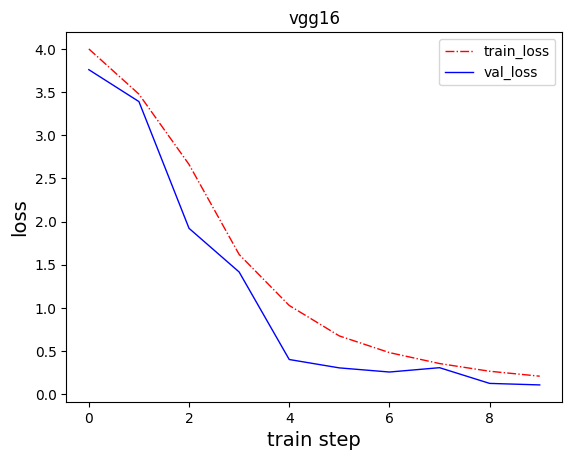

In [46]:
weight_decay = 1e-3

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(parameters, lr = learning_rate, weight_decay = weight_decay)
#optimizer = torch.optim.SGD(parameters, lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=10, model_name='vgg16.ckpt',
                                     device=device)
plot_loss(losses_list, val_losses_list, "vgg16", 10)

In [50]:
#Evaluate the model
print('Accuracy efficientnet Transfer Learning:')
print(f'Training Accuracy: {test(model, train_loader)}')
print(f'Validation Accuracy: {test(model, val_loader)}')
print(f'Testing Accuracy: {test(model, test_loader)}')

Accuracy efficientnet Transfer Learning:
Training Accuracy: 94.17628541448059
Validation Accuracy: 98.11320754716981
Testing Accuracy: 92.0754716981132


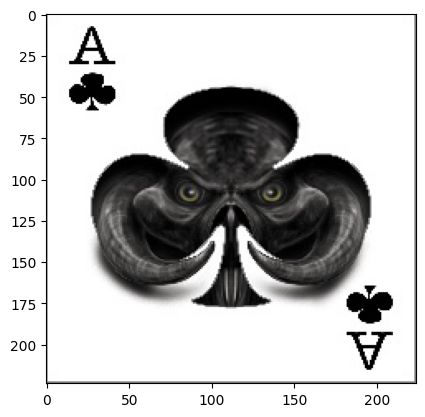

ace of clubs


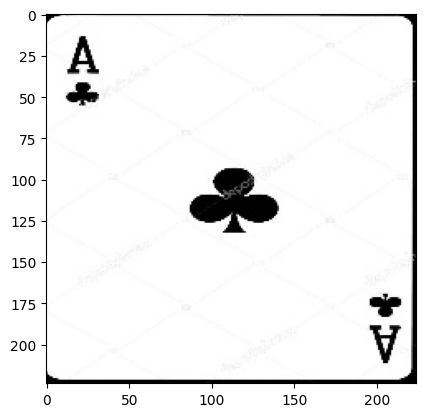

ace of clubs


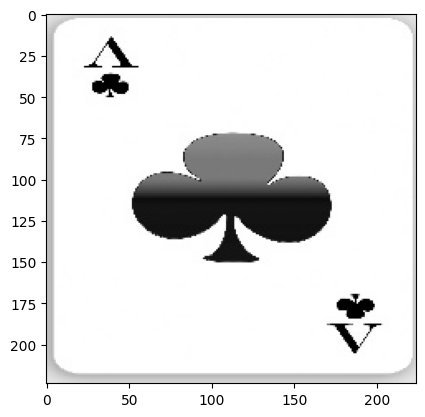

ace of clubs


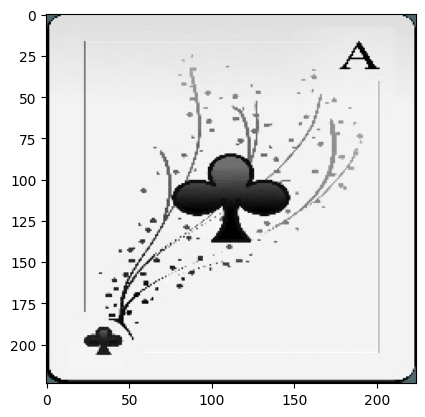

ace of clubs


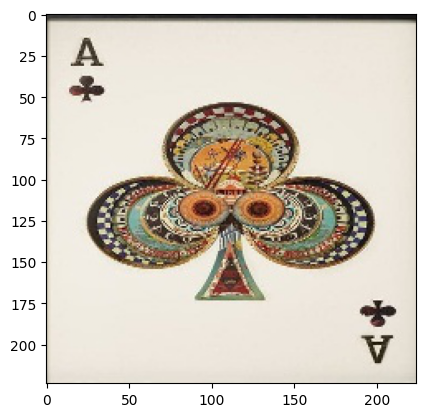

ace of clubs


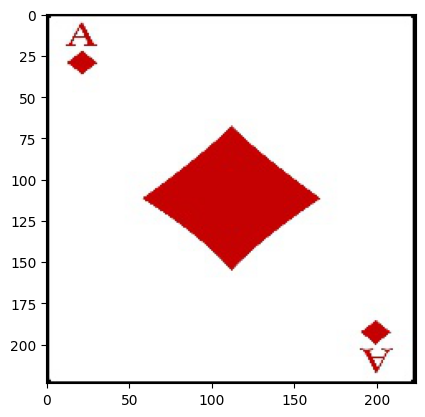

ace of diamonds


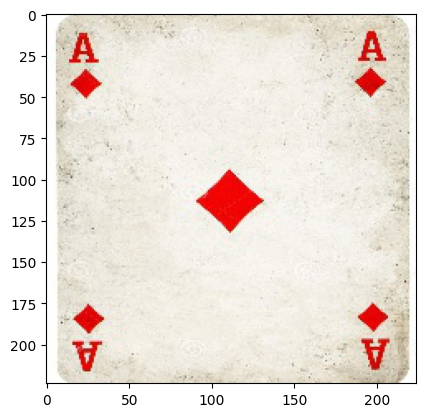

ace of diamonds


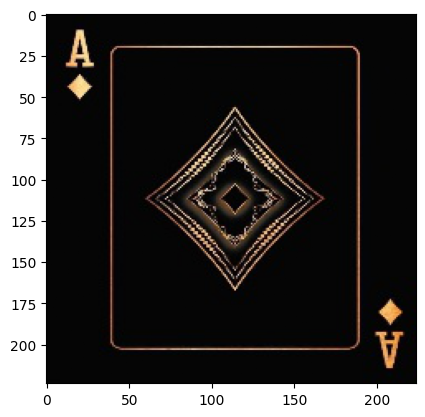

ace of diamonds


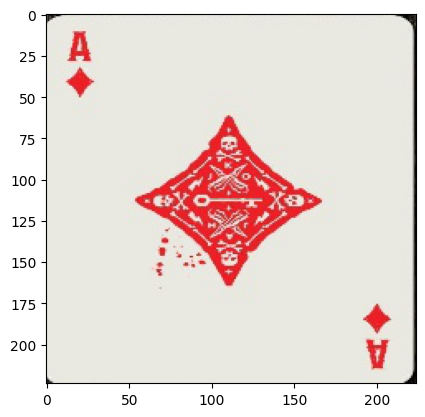

ace of diamonds


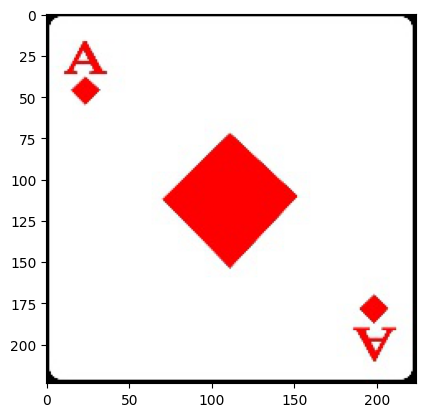

ace of diamonds


In [6]:

#MyModelv2 accuracy
model = vgg16()

num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.Linear(512, 53)
)

model.load_state_dict(torch.load(results_path + '/vgg16.ckpt', map_location=torch.device('cpu')))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# try some real images we took
model.eval()
image_path = '/content/poker/test'
#image_path = "/content/drive/Shareddrives/Deep Learning/Final/Data/real test"
model.to(device)

# Try with cropping
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor()
   # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
)

real_dataset = Dataset(image_path, tr)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=10, shuffle=False)

images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

for i, image in enumerate(images):
  image = image.cpu()
  plt.imshow(image.permute(1, 2, 0))
  plt.show()
  print(number_to_labels[predicted[i].item()])


## CAM

1.000 -> eight of clubs
0.000 -> eight of spades
0.000 -> eight of hearts
0.000 -> nine of clubs
0.000 -> six of clubs
(512, 7, 7)
Output CAM.jpg for the top1 prediction: eight of clubs


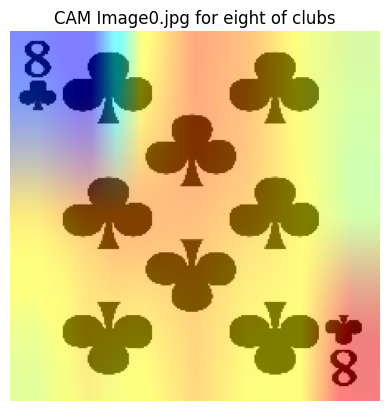

In [7]:
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
import cv2
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape

    print(feature_conv.shape)

    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.resize(cam, (width, height))

        # Apply colormap 'jet' using OpenCV
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert the heatmap to PIL Image format
        heatmap_pil = Image.fromarray(heatmap)

        # Convert the original image to PIL Image format
        transform = tf.ToPILImage()
        orig_image_pil = transform(orig_image.squeeze())

        # Resize the heatmap to match the size of the original image
        heatmap_resized = heatmap_pil.resize((orig_image_pil.width, orig_image_pil.height), Image.ANTIALIAS)

        # Blend the heatmap with the original image using alpha blending
        blended_image = Image.blend(orig_image_pil, heatmap_resized, alpha=0.5)

        # Convert the blended image back to numpy array
        blended_image_np = np.array(blended_image)

        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the blended image
        ax.imshow(blended_image_np)
        ax.axis('off')
        ax.set_title(f'CAM {save_name} for {class_idx[i]}')

        # Show the plot
        plt.show()

        # Save the image
        fig.savefig(f"{results_path}/CAM_{save_name}.jpg")
        plt.close(fig)


model.eval()

features_blobs = []

model._modules.get("features").register_forward_hook(hook_feature)


# Get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

# Load a test image
loader_iter = iter(real_loader)
next(loader_iter)
next(loader_iter)
images, labels = next(loader_iter)
images = images.to(device)
# print(images.shape)
outputs = F.softmax(model(images), dim=1)

for img_idx in range(len(features_blobs)):
    labeled_outputs = [(label, prob) for label, prob in enumerate(outputs.detach().cpu().numpy()[img_idx])]
    labeled_outputs.sort(key=lambda a: a[1], reverse=True)

    # Output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(labeled_outputs[i][1], number_to_labels[labeled_outputs[i][0]]))

    # Generate class activation mapping for the top1 prediction
    CAMs = returnCAM(features_blobs[img_idx][0], weight_softmax, [labeled_outputs[0][0]])

    # Render the CAM and output
    print('Output CAM.jpg for the top1 prediction: %s' % number_to_labels[labeled_outputs[0][0]])
    height, width, _ = images[img_idx].shape

    show_cam(CAMs, width, height, images[img_idx], [number_to_labels[labeled_outputs[i][0]] for i in range(5)], f"Image{img_idx}.jpg")

# Efficient Net

In [55]:
# code adapted from: https://www.kaggle.com/code/abdallahwagih/effecientnetb3-cards-classification-98-85

from torchvision.models import efficientnet_b3

import random
import math

#Initialize random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# free cuda memory
gc.collect()
torch.cuda.empty_cache()

model = efficientnet_b3(weights='DEFAULT')

# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(num_features, class_count),
#     nn.LogSoftmax(dim=1)
# )

# change classifier layers
model.classifier = nn.Sequential(
    #nn.BatchNorm1d(num_features, eps=0.001, momentum=0.99),
    nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.45),
    nn.Linear(256, class_count),
    nn.LogSoftmax(dim=1)
)

parameters = list(model.classifier.parameters())
layers_n = len(model.features)

# there are 9 sequentials in features, we will train half of them
for i in range(math.ceil(layers_n / 2), layers_n):
  parameters += list(model.features[i].parameters())
  for param in model.features[i].parameters():
      param.requires_grad = True


In [ ]:
weight_decay = 1e-3

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(parameters, lr = learning_rate, weight_decay = weight_decay)
#optimizer = torch.optim.SGD(parameters, lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

losses_list, val_losses_list = train(model, train_loader, val_loader, optimizer,
                                     num_epochs=10, model_name='eficientnet.ckpt',
                                     device=device)
plot_loss(losses_list, val_losses_list, "efficientnet", 10)

In [ ]:
#Evaluate the model
print('Accuracy efficientnet Transfer Learning:')
print(f'Training Accuracy: {test(model, train_loader)}')
print(f'Validation Accuracy: {test(model, val_loader)}')
print(f'Testing Accuracy: {test(model, test_loader)}')

Accuracy efficientnet Transfer Learning:
Training Accuracy: 95.79398391045821
Validation Accuracy: 95.84905660377359
Testing Accuracy: 93.20754716981132


In [56]:

#MyModelv2 accuracy
model = efficientnet_b3()


model.classifier = nn.Sequential(
    #nn.BatchNorm1d(num_features, eps=0.001, momentum=0.99),
    nn.BatchNorm1d(num_features),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, class_count),
    nn.Softmax(dim=1)
)

model.load_state_dict(torch.load(results_path + '/eficientnet-original-database.ckpt', map_location=torch.device('cpu')))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# try some real images we took
model.eval()
image_path = '/content/poker/test'
image_path = "/content/drive/Shareddrives/Deep Learning/Final/Data/real test"
model.to(device)

# Try with cropping
tr = tf.Compose([
    tf.Resize((224, 224)),
    tf.ToTensor()
   # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
)

real_dataset = Dataset(image_path, tr)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=10, shuffle=False)

images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

for i, image in enumerate(images):
  image = image.cpu()
  plt.imshow(image.permute(1, 2, 0))
  plt.show()
  print(number_to_labels[predicted[i].item()])


FileNotFoundError: ignored

## CAM

0.768 -> four of diamonds
0.133 -> ace of diamonds
0.046 -> king of diamonds
0.032 -> queen of spades
0.003 -> seven of diamonds
Output CAM.jpg for the top1 prediction: four of diamonds


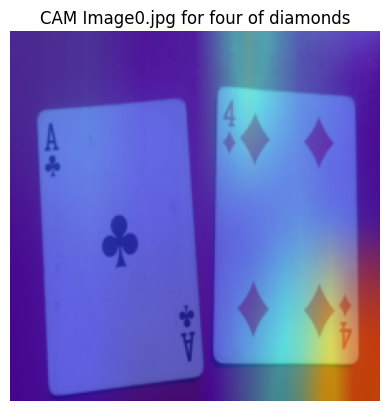

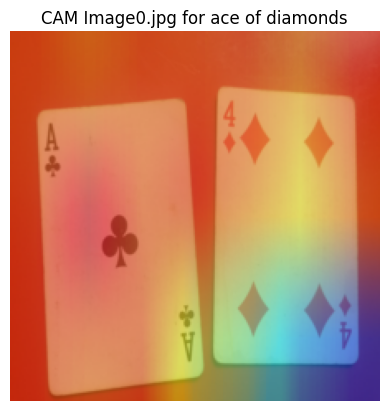

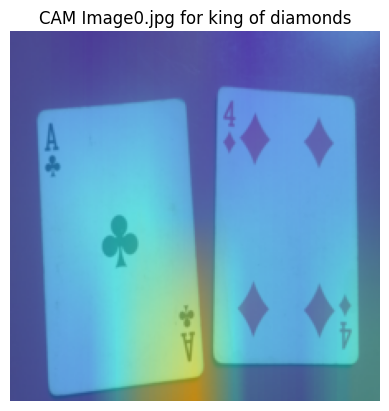

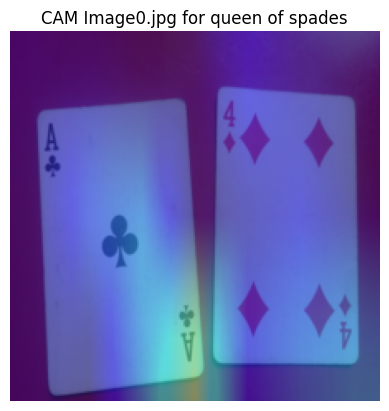

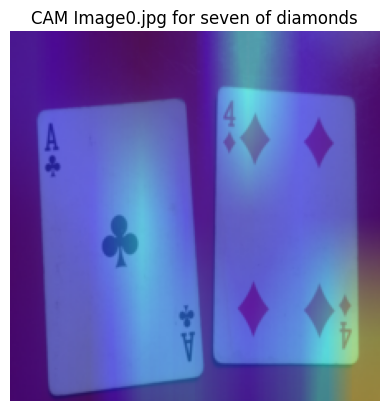

In [ ]:
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
import cv2
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape

    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.resize(cam, (width, height))

        # Apply colormap 'jet' using OpenCV
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert the heatmap to PIL Image format
        heatmap_pil = Image.fromarray(heatmap)

        # Convert the original image to PIL Image format
        transform = tf.ToPILImage()
        orig_image_pil = transform(orig_image.squeeze())

        # Resize the heatmap to match the size of the original image
        heatmap_resized = heatmap_pil.resize((orig_image_pil.width, orig_image_pil.height), Image.ANTIALIAS)

        # Blend the heatmap with the original image using alpha blending
        blended_image = Image.blend(orig_image_pil, heatmap_resized, alpha=0.5)

        # Convert the blended image back to numpy array
        blended_image_np = np.array(blended_image)

        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the blended image
        ax.imshow(blended_image_np)
        ax.axis('off')
        ax.set_title(f'CAM {save_name} for {class_idx[i]}')

        # Show the plot
        plt.show()

        # Save the image
        fig.savefig(f"{results_path}/CAM_{save_name}.jpg")
        plt.close(fig)


model.eval()

features_blobs = []

model._modules.get("features").register_forward_hook(hook_feature)


# Get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-4].data.cpu().numpy())

# Load a test image
images, labels = next(iter(real_loader))
images = images.to(device)
# print(images.shape)
outputs = model(images)
for img_idx in range(len(features_blobs)):
    labeled_outputs = [(label, prob) for label, prob in enumerate(outputs.detach().cpu().numpy()[img_idx])]
    labeled_outputs.sort(key=lambda a: a[1], reverse=True)

    # Output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(labeled_outputs[i][1], number_to_labels[labeled_outputs[i][0]]))

    # Generate class activation mapping for the top1 prediction
    CAMs = returnCAM(features_blobs[img_idx][0], weight_softmax, [labeled_outputs[i][0] for i in range(5)])

    # Render the CAM and output
    print('Output CAM.jpg for the top1 prediction: %s' % number_to_labels[labeled_outputs[0][0]])
    height, width, _ = images[img_idx].shape

    show_cam(CAMs, width, height, images[img_idx], [number_to_labels[labeled_outputs[i][0]] for i in range(5)], f"Image{img_idx}.jpg")